# E5. Image Similarity using embedding vector

### **실습 목차**
0. 실습 개요 및 insight
1. 사진의 얼굴 영역 임베딩 벡터 추출   
    1-1. 사용할 함수 정의   
    1-2. custom 함수를 활용해 진행
    
2. 나랑 비슷한 연예인은 누구..?
3. Visualization of embedding vectors    
    3-1. PCA 모델을 활용한 시각화    
    3-2. TSNE 모델을 활용한 시각화
4. 회고
   
    <br>

**0-1. 실습개요**
: face_recognition 패키지를 활용해서 얼굴을 인식하고, face locations를 찾아 임베딩 벡터로 변환(face_encodings API활용-아래 그림)한 다음에 임베딩 벡터 간 거리로 닮은 꼴을 찾아냅니다.

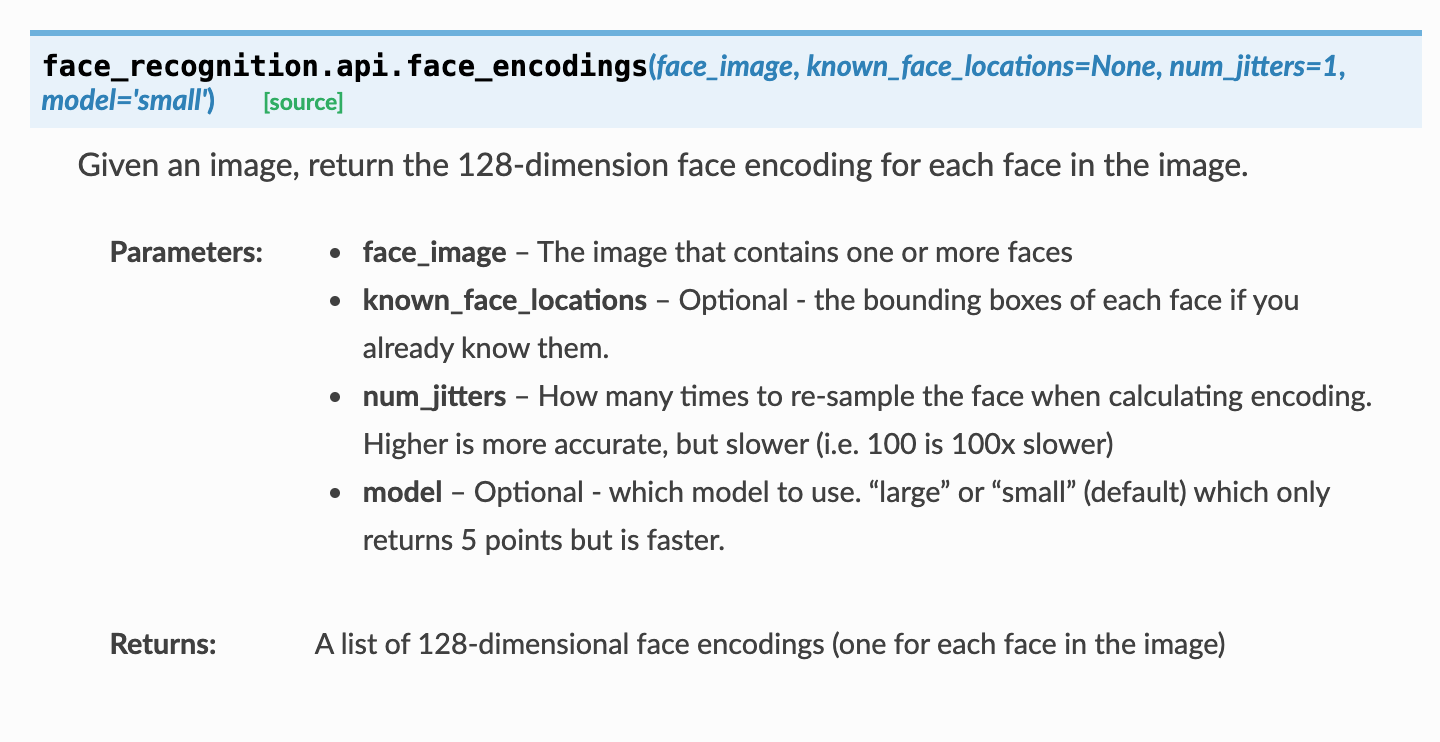

**0-2. 실습 insight** : 오늘 실습할 닮은꼴 이미지 찾기가 실생활에 어떻게 사용되고 있는지 insight를 적었습니다.   

"Image similarity detection is used to *quantify the degree of visual and semantic similarity of the images.* Duplicate product detection(모조품 발견), image clustering(이미지 군집화), visual search(시각적 탐색), and recommendation(추천) tasks are performed with this technology in modern applications." (출처:[참고 링크](https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509)). 인용한 이 링크에서는 고객에게 비슷한 패션 상품을 찾아서 보여주는데에 image similarity detection을 활용했다고 합니다.   

요즘 쇼핑몰 앱에서 이런 기능을 많이 제공하고 있는데요, 디자인이 비슷한 옷도 조금씩 미세하게 다르고 가격대도 다르기 때문에 내가 사고싶은 브랜드, 느낌, 가격대 상품들을 한번에 비교할 수 있어서 좋은 것 같아요!

# 1. 사진의 얼굴 영역 임베딩 벡터 추출

In [1]:
!pip3 install face_recognition # 코랩에 face_recognition 패키지를 설치

In [ ]:
#matplotlib에 한글 주석을 넣어주기 위해
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
# 필요한 패키지 불러오기

from PIL import Image
import face_recognition
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import cv2
from skimage.transform import resize

import unicodedata
def unicode(name):
  return unicodedata.normalize("NFC", name) #코랩에서는 왜인지.. 한글 파일이름이 한글 string이랑 비교하면 false가 나와서 unicode normalize를 해줬습니다.

In [3]:
plt.rcParams["font.family"] = 'NanumBarunGothic'
print(plt.rcParams['font.family'])

['NanumBarunGothic']


In [4]:
!ls

drive  sample_data


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1-1. 사용할 함수 정의

- **get_cropped_face(path_dir)**: 사진에서 얼굴 영역을 잘라낸 후 PIL Image 로 변환해서 저장
- **get_face_embedding(image)**: face_recognition 의 face_encodings 함수로 잘라낸 얼굴 영역의 임베딩 벡터를 구하는 함수
- **get_face_embedding_dict(path_dir)**: 지정한 경로에 있는 이미지들에 대해 얼굴 임베딩 벡터를 구하고 딕셔너리로 저장
- **get_distance(name1, name2)**: 임베딩 벡터 간 거리를 구하는 함수
- **get_sort_key_func(name1)**: name1과 name2의 거리를 비교하는데, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 하는 함수
- **get_nearest_face(name, top=5)**: 입력한 name과 닮은 사람을 순위별로 5위까지 나열하고 이미지로 출력해주는 함수.

In [26]:
# get_cropped_face 함수를 정의합니다.

def get_cropped_face(path_dir):
  '''
  face_recognition 패키지를 활용해 얼굴을 인식해 잘라내고,
  pillow의 Image.fromarray로 PIL Image로 변환 후 저장하는 함수입니다.

  path_dir: 읽어올 이미지가 있는 경로
  '''
  
  file_list = os.listdir(path_dir)
  cropped_face_dict={}       # 잘라준 얼굴영역 array를 모아줍니다.
  cropped_face_vec={}

  for i, file in tqdm(enumerate(file_list)):
    if file == "cropped": continue     # celebrity 디렉토리 안에 얼굴 영역을 자른 파일을 모아줄 cropped 디렉토리는 패스한다.
    file_name = os.path.splitext(file)[0]
    file_name = unicode(file_name)
    image = face_recognition.load_image_file(os.path.join(path_dir, file))
    face_locations = face_recognition.face_locations(image)

    if face_locations == []:
      continue

    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    cropped_face_dict["{}".format(file_name)] = cropped_face
    cropped_face_vec["{}".format(file_name)] = resize(cropped_face, (50,50))
    Image.fromarray(cropped_face).save("{}/cropped/{}.jpg".format(path_dir,file_name))  # PIL image 로 바꾼후 저장
  
  print("-----------------------------")
  print("face crop success")
  return cropped_face_dict, cropped_face_vec

In [7]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

# 디렉토리 내의 이미지에 대해 얼굴 임베딩 벡터를 딕셔너리로 저장
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in tqdm(file_list):
        img_path = os.path.join(dir_path, file)
        file_name = os.path.splitext(file)[0]
        file_name = unicode(file_name)
        embedding = get_face_embedding(cropped_face_dict[file_name])
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            embedding_dict[file_name] = embedding[0]
    
    print("-----------------------------")
    print("embedding vector success\n")    
    return embedding_dict

In [8]:
# 두 개의 임베딩 벡터 사이의 거리를 구하는 함수를 정의합니다.
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [9]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

# 입력한 이름과 임베딩 벡터 거리가 가까운 5개 이미지를 출력합니다.
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)  
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))    # 입력한 name과 가까운 순으로 정렬
    im_name = cv2.imread(os.path.join(cropped_path,"{}.jpg".format(name)))
    im_name = cv2.resize(im_name, (200,200))

    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            print('입력한 이름: {}'.format(sorted_faces[i][0]))
            plt.imshow(cropped_face_dict[unicode(sorted_faces[i][0])])
            plt.show()
            print("-----------------------------")
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            print('대략 {}% 닮았네요!'.format(round((1-sort_key_func(sorted_faces[i][0]))*100))) # 재미를 위해 닮은 정도를 확률로 나타냈습니다.
            # 닮은 정도를 나타내는 식을 정해줬습니다: (1-임베딩 벡터 거리)*100
            plt.imshow(cropped_face_dict[unicode(sorted_faces[i][0])])
            plt.show()

            im_similar = cv2.imread(os.path.join(cropped_path,"{}.jpg".format(sorted_faces[i][0])))
            im_similar = cv2.resize(im_similar, (200,200))
            dst = cv2.addWeighted(im_name, 0.5, im_similar, 0.5, 0.0)  # 이미지를 겹쳐 보면서 얼마나 비슷한지 비교해 보려고 합니다.
            plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
            plt.show()
            print("-----------------------------")
    return sorted_faces      # 정렬한 리스트 반환

### 1-2. custom 함수를 활용해 진행

In [27]:
path_dir = '/content/drive/MyDrive/celebrity'   # 연예인 사진들을 모아둔 파일 경로를 불러옵니다.
#os.mkdir(os.path.join(path_dir, 'cropped')) # 얼굴만 자른 사진을 모아줄 하위 디렉토리 생성

cropped_face_dict, cropped_face_vec = get_cropped_face(path_dir) # 사진에서 얼굴 영역을 인식해 저장합니다.
print("얼굴 인식 성공한 파일 개수:",len(cropped_face_dict))

2370it [03:14, 12.16it/s]

-----------------------------
face crop success
얼굴 인식 성공한 파일 개수: 2225


In [11]:
cropped_path = os.path.join(path_dir, "cropped")

embedding_dict = get_face_embedding_dict(cropped_path)    # 얼굴의 임베딩 벡터를 dictionary로 가져옵니다.
print("임베딩 벡터 구한 얼굴 개수: ", len(embedding_dict))
print("-----------------------------")
file_list = os.listdir(cropped_path)

100%|██████████| 2225/2225 [00:35<00:00, 62.06it/s] 

-----------------------------
embedding vector success

임베딩 벡터 구한 얼굴 개수:  2020
-----------------------------


In [12]:
print("나는 내 사진과 얼마나 닮았을까?")
get_distance('나', '나2')

나는 내 사진과 얼마나 닮았을까?


0.31827305501881903


샘플1: 이성민


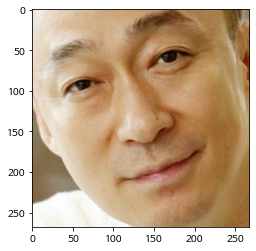


샘플2: 정일화


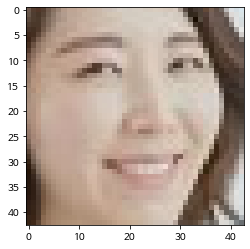

이성민, 정일화 둘이 얼마나 닮았을까? 0.7213662521127591


In [13]:
# file_list에서 랜덤으로 두개의 이미지와 embedding vector를 확인하고, 거리 구하기
sample = random.sample(file_list, 2)   # random으로 file_list에서 2개 파일을 추출합니다.

for idx,file in enumerate(sample):
  file_name = unicode(os.path.splitext(file)[0])
  print("\n샘플{}:".format(idx+1),file_name)
  plt.imshow(cropped_face_dict[file_name])
  plt.show()

name1=unicode(os.path.splitext(sample[0])[0])
name2=unicode(os.path.splitext(sample[1])[0])
print("{}, {} 둘이 얼마나 닮았을까?".format(name1, name2), get_distance(name1, name2))

- 같은 사람의 임베딩 벡터 거리는 0.3 정도로 나왔고, 닮았으면 거리가 더 짧고, 닮지 않았으면 거리가 더 길게 나옵니다.

# 2. 나랑 비슷한 연예인은 누구..?

- 위에서 정의한 get_nearest_face 함수를 사용해서 내 사진과 비슷한 연예인 얼굴을 찾아봅시다.

입력한 이름: 나


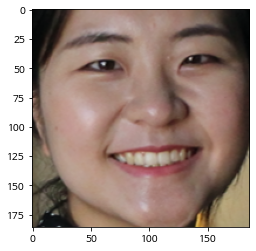

-----------------------------
순위 1 : 이름(나2), 거리(0.31827305501881903)
대략 68% 닮았네요!


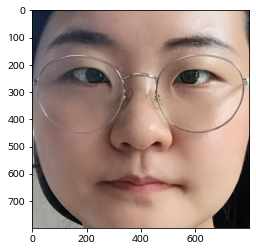

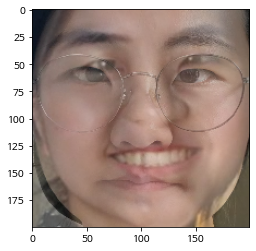

-----------------------------
순위 2 : 이름(성민준), 거리(0.4292831811766916)
대략 57% 닮았네요!


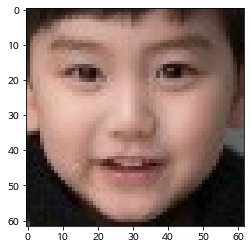

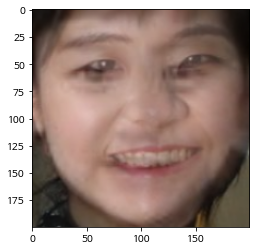

-----------------------------
순위 3 : 이름(안소희), 거리(0.4361201515293025)
대략 56% 닮았네요!


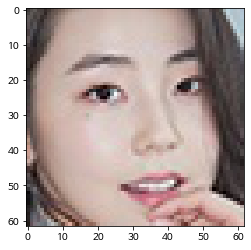

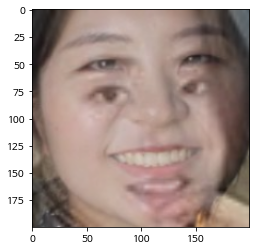

-----------------------------
순위 4 : 이름(박선주), 거리(0.443414911729719)
대략 56% 닮았네요!


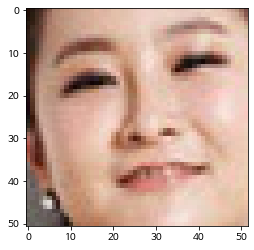

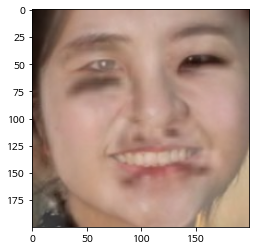

-----------------------------
순위 5 : 이름(노영심), 거리(0.44361711369335355)
대략 56% 닮았네요!


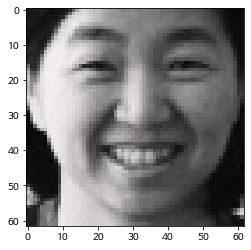

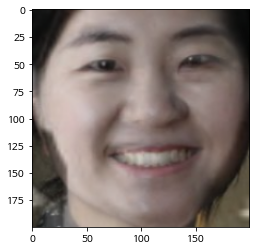

-----------------------------


In [14]:
nearest = get_nearest_face('나')   # 입력한 이름인 '나'의 image 와 닮은 구석이 많은 5개 이미지를 출력해줍니다.

- 흠... 제 생각엔 나름 비슷한 구석이 있는 것도 같은데 어떠신가요..?
- 이미지를 겹쳐서 시각화하려고 했는데, 눈/코/입 위치가 안맞아서 조금 괴상한 얼굴 사진이 되어버렸습니다. 겹쳐 보면 어디가 어떻게 비슷한지 보일 것 같았는데 다른 방법도 찾아봐야겠습니다.

# 3. Visualization of embedding vectors

- 임베딩 벡터를 visualization할 방법에 대해서 고민했는데, 노드에서 배웠던 PCA(주성분분석), t-SNE(확률적 방법)에 대해서 찾아봤습니다. 고차원 벡터를 저차원으로 압축해준 뒤, 벡터 간 거리가 가까울수록 x-y 좌표평면에 가깝게 배치하는 원리로 작동합니다. 다음 링크들을 참고해서 코드를 작성했습니다.
([[1]](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b),[[2]](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne))
1번 링크에서는 MNIST 데이터셋의 digits를 시각화하는 방법에 대해서 PCA, t-SNE 두 가지 기법을 소개해주었습니다. 그리고 2번 링크에서는 nlp 에서 word2vec 을 해준 뒤 t-SNE로 시각화했으며 word2vec 부분을 빼고 embedding vector 를 좌표평면에 나타내는 코드만 참고했습니다. 그렇기에 조금 미숙할 수 있습니다. 이 링크를 참고한 전제는, 자연어든 이미지든 고차원 벡터를 저차원으로 embedding vector로 변환해주었다면 거리를 계산하는 알고리즘은 같은 원리일 것이라는 제 생각이었습니다.
- 앞에서 구해준 각 사람의 얼굴 임베딩 벡터를 담은 embedding_dict를 sorted한 리스트에서 label과 vector를 가져와서 시각화해주었습니다.

**t-SNE**   
t-Stochastic Neighbor Embedding의 약자이며, 비선형 차원축소 기법들 중 하나이다. 고차원 벡터를 저차원으로 차원 축소하며, 비슷한 점들을 모아서 2차원 평면에 시각화해준다. manifold 방식으로 진행되며, 갱신횟수가 증가할수록 거리가 가까운 것끼리 모아준다. (사진은 t-SNE 로 시각화한 결과물의 대략적인 모습, [출처](https://gaussian37.github.io/ml-concept-t_sne/))    

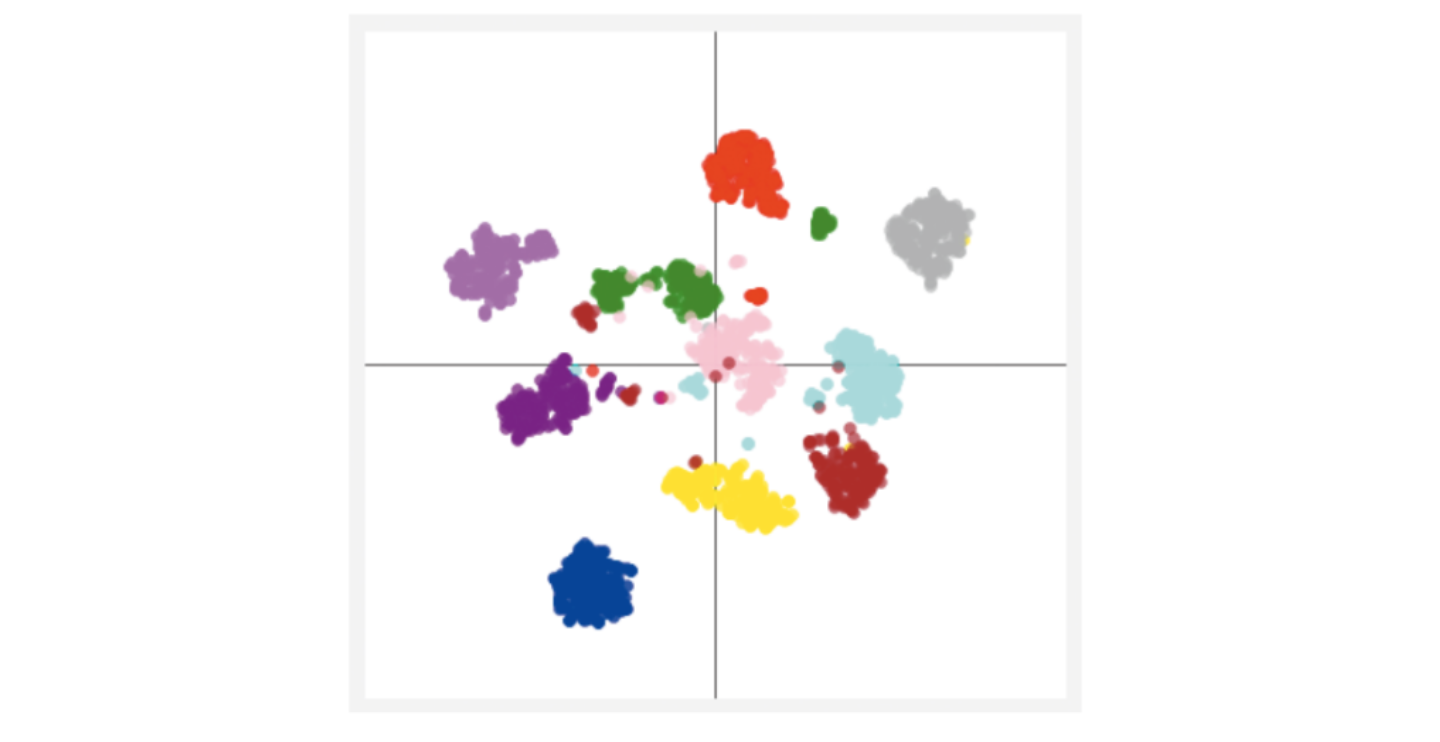

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

In [28]:
# 얼굴 이미지의 50*50*3 cropped_face_vec(고차원 벡터)을 pandas DataFrame으로 변환
for key, value in cropped_face_vec.items():
  cropped_face_vec[key] = value.reshape(-1,)
X = list(cropped_face_vec.values())
cropped_df = pd.DataFrame(X)

In [17]:
# embedding vector(128차원 저차원 벡터) 리스트 생성
labels = []
vectors = []

for image in tqdm(nearest):
  vectors.append(image[1])
  labels.append(image[0])

100%|██████████| 2020/2020 [00:00<00:00, 602852.86it/s]


### 3-1. PCA 모델을 활용한 시각화

- 먼저 고차원 벡터를 PCA 모델로 시각화해본 후 저차원 임베딩 벡터를 PCA 모델로 시각화해봅니다. 2차원, 3차원으로 시각화해볼 것입니다.

In [18]:
# PCA(주성분분석)로 얼굴 이미지 벡터를 학습하고 visualize하는 함수 정의
def model_pca(input, df):
  pca = PCA(n_components=3)           # 저장할 주성분 개수를 3개로 설정합니다.
  pca_result = pca.fit_transform(input)     # 임베딩 벡터의 차원 축소와 모델 학습
  df['pca-one'] = pca_result[:,0]
  df['pca-two'] = pca_result[:,1] 
  df['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
  
  # x-y좌표평면 2차원으로 시각화해보기
  rndperm = np.random.permutation(df.shape[0])

  plt.figure(figsize=(16,10))
  sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
  )

  # 3차원으로 표현해보기
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')
  ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    cmap='tab10'
  )
  ax.set_xlabel('pca-one')
  ax.set_ylabel('pca-two')
  ax.set_zlabel('pca-three')
  plt.show()

Explained variation per principal component: [0.21046701 0.13336729 0.09981583]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


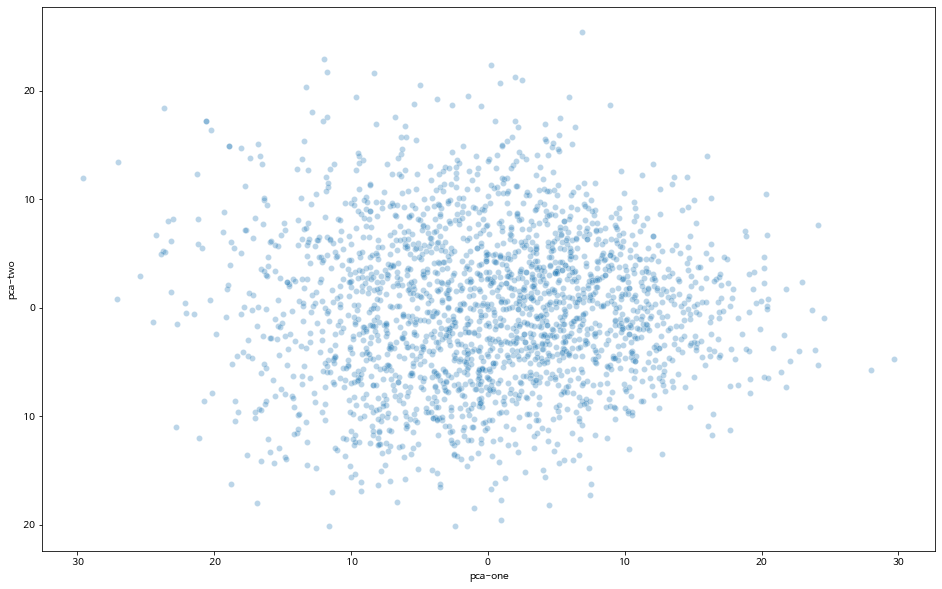

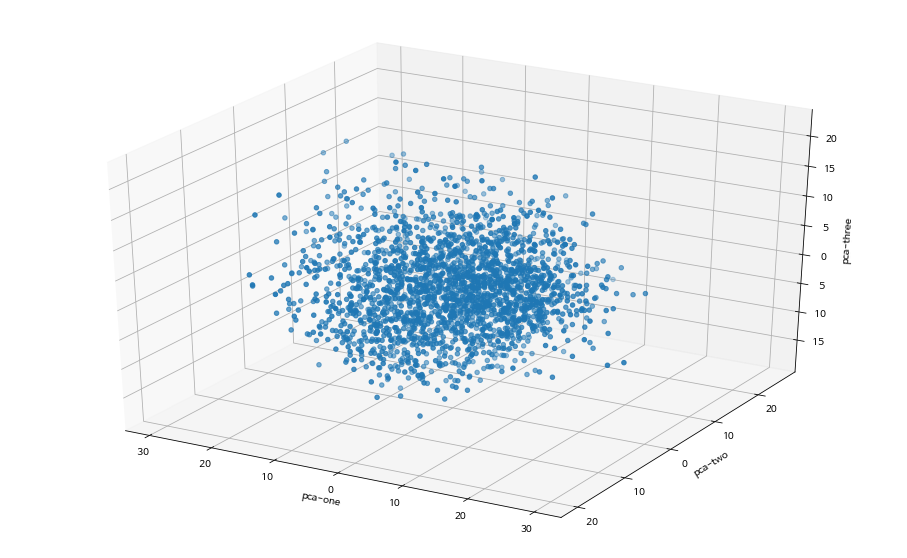

In [19]:
#PCA(주성분분석)로 고차원 벡터 학습하기
model_pca(X, cropped_df)

Explained variation per principal component: [0.15854646 0.06381245 0.04697128]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


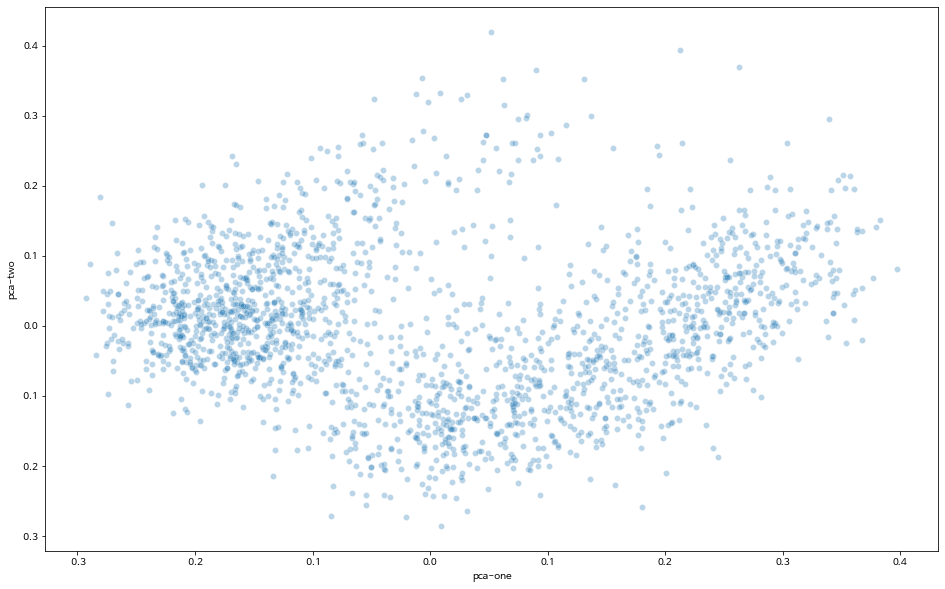

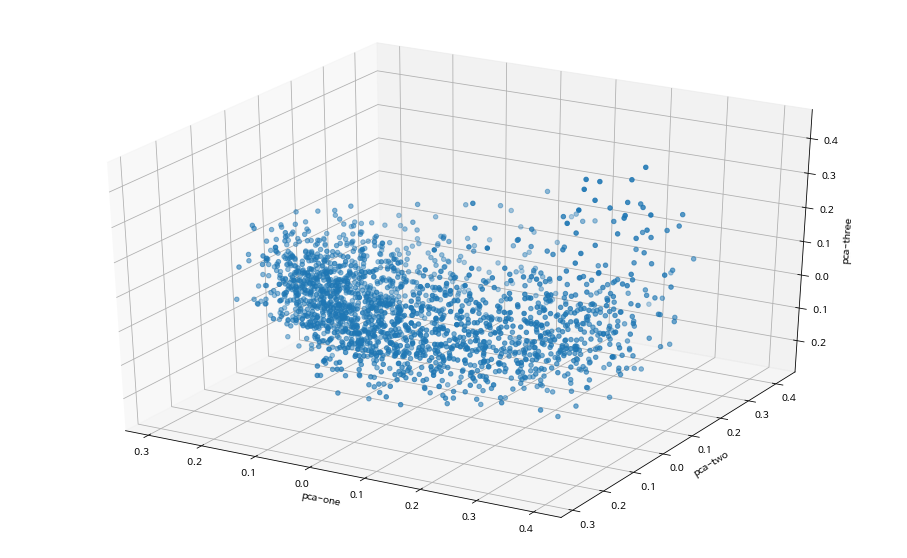

In [20]:
# PCA(주성분분석)로 임베딩 벡터를 학습하기
df = pd.DataFrame(vectors)
model_pca(vectors, df)

- 고차원 벡터를 PCA 모델로 시각화해보니, 점들이 상관관계가 거의 없는 것으로 나옵니다. 분류를 잘했다고 보기 어렵습니다.
- 임베딩벡터를 PCA 모델로 시각화해보니 비슷한 이미지들끼리 모여있는 모습을 볼 수 있습니다. 각 점이 어떤 사람인지 주석은 없지만, 성별에 따라 비슷하게 분포하고 있을 것으로 예상되므로 남/여 두 영역으로 구분되고 있습니다. 뒤에서는 t-SNE 로 시각화하면서 각 점에 주석도 붙여보겠습니다. 

### 3-2. TSNE 모델을 활용한 시각화

- 마찬가지로, 고차원 벡터와 임베딩 벡터 각각을 tsne 모델로 학습한 뒤 시각화해봅니다.

#### 1) 고차원 벡터

In [38]:
# 얼굴 이미지 벡터를 tsne로 학습하는 함수를 정의합니다.
def model_tsne(vector, labels):
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)   # 2500회 반복
  new_values = tsne_model.fit_transform(vector)   # 이미지 임베딩 벡터를 학습합니다.
  
  # t-SNE 모델로 학습한 점들을 x-y 좌표평면에 나타냅니다.
  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
  plt.figure(figsize=(50, 25)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
  plt.show()

  #3차원으로 시각화
  tsne_3d = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  tsne3 = tsne_3d.fit_transform(vector)
  tsne_df3 = pd.DataFrame({'x':tsne3[:,0], 'y':tsne3[:,1],'z':tsne3[:,2], 'classes':labels})
  
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')
  ax.scatter(
    xs=tsne_df3["x"], 
    ys=tsne_df3["y"], 
    zs=tsne_df3["z"], 
    cmap='tab10'
  )
  ax.set_xlabel('tsne-one')
  ax.set_ylabel('tsne-two')
  ax.set_zlabel('tsne-three')
  plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


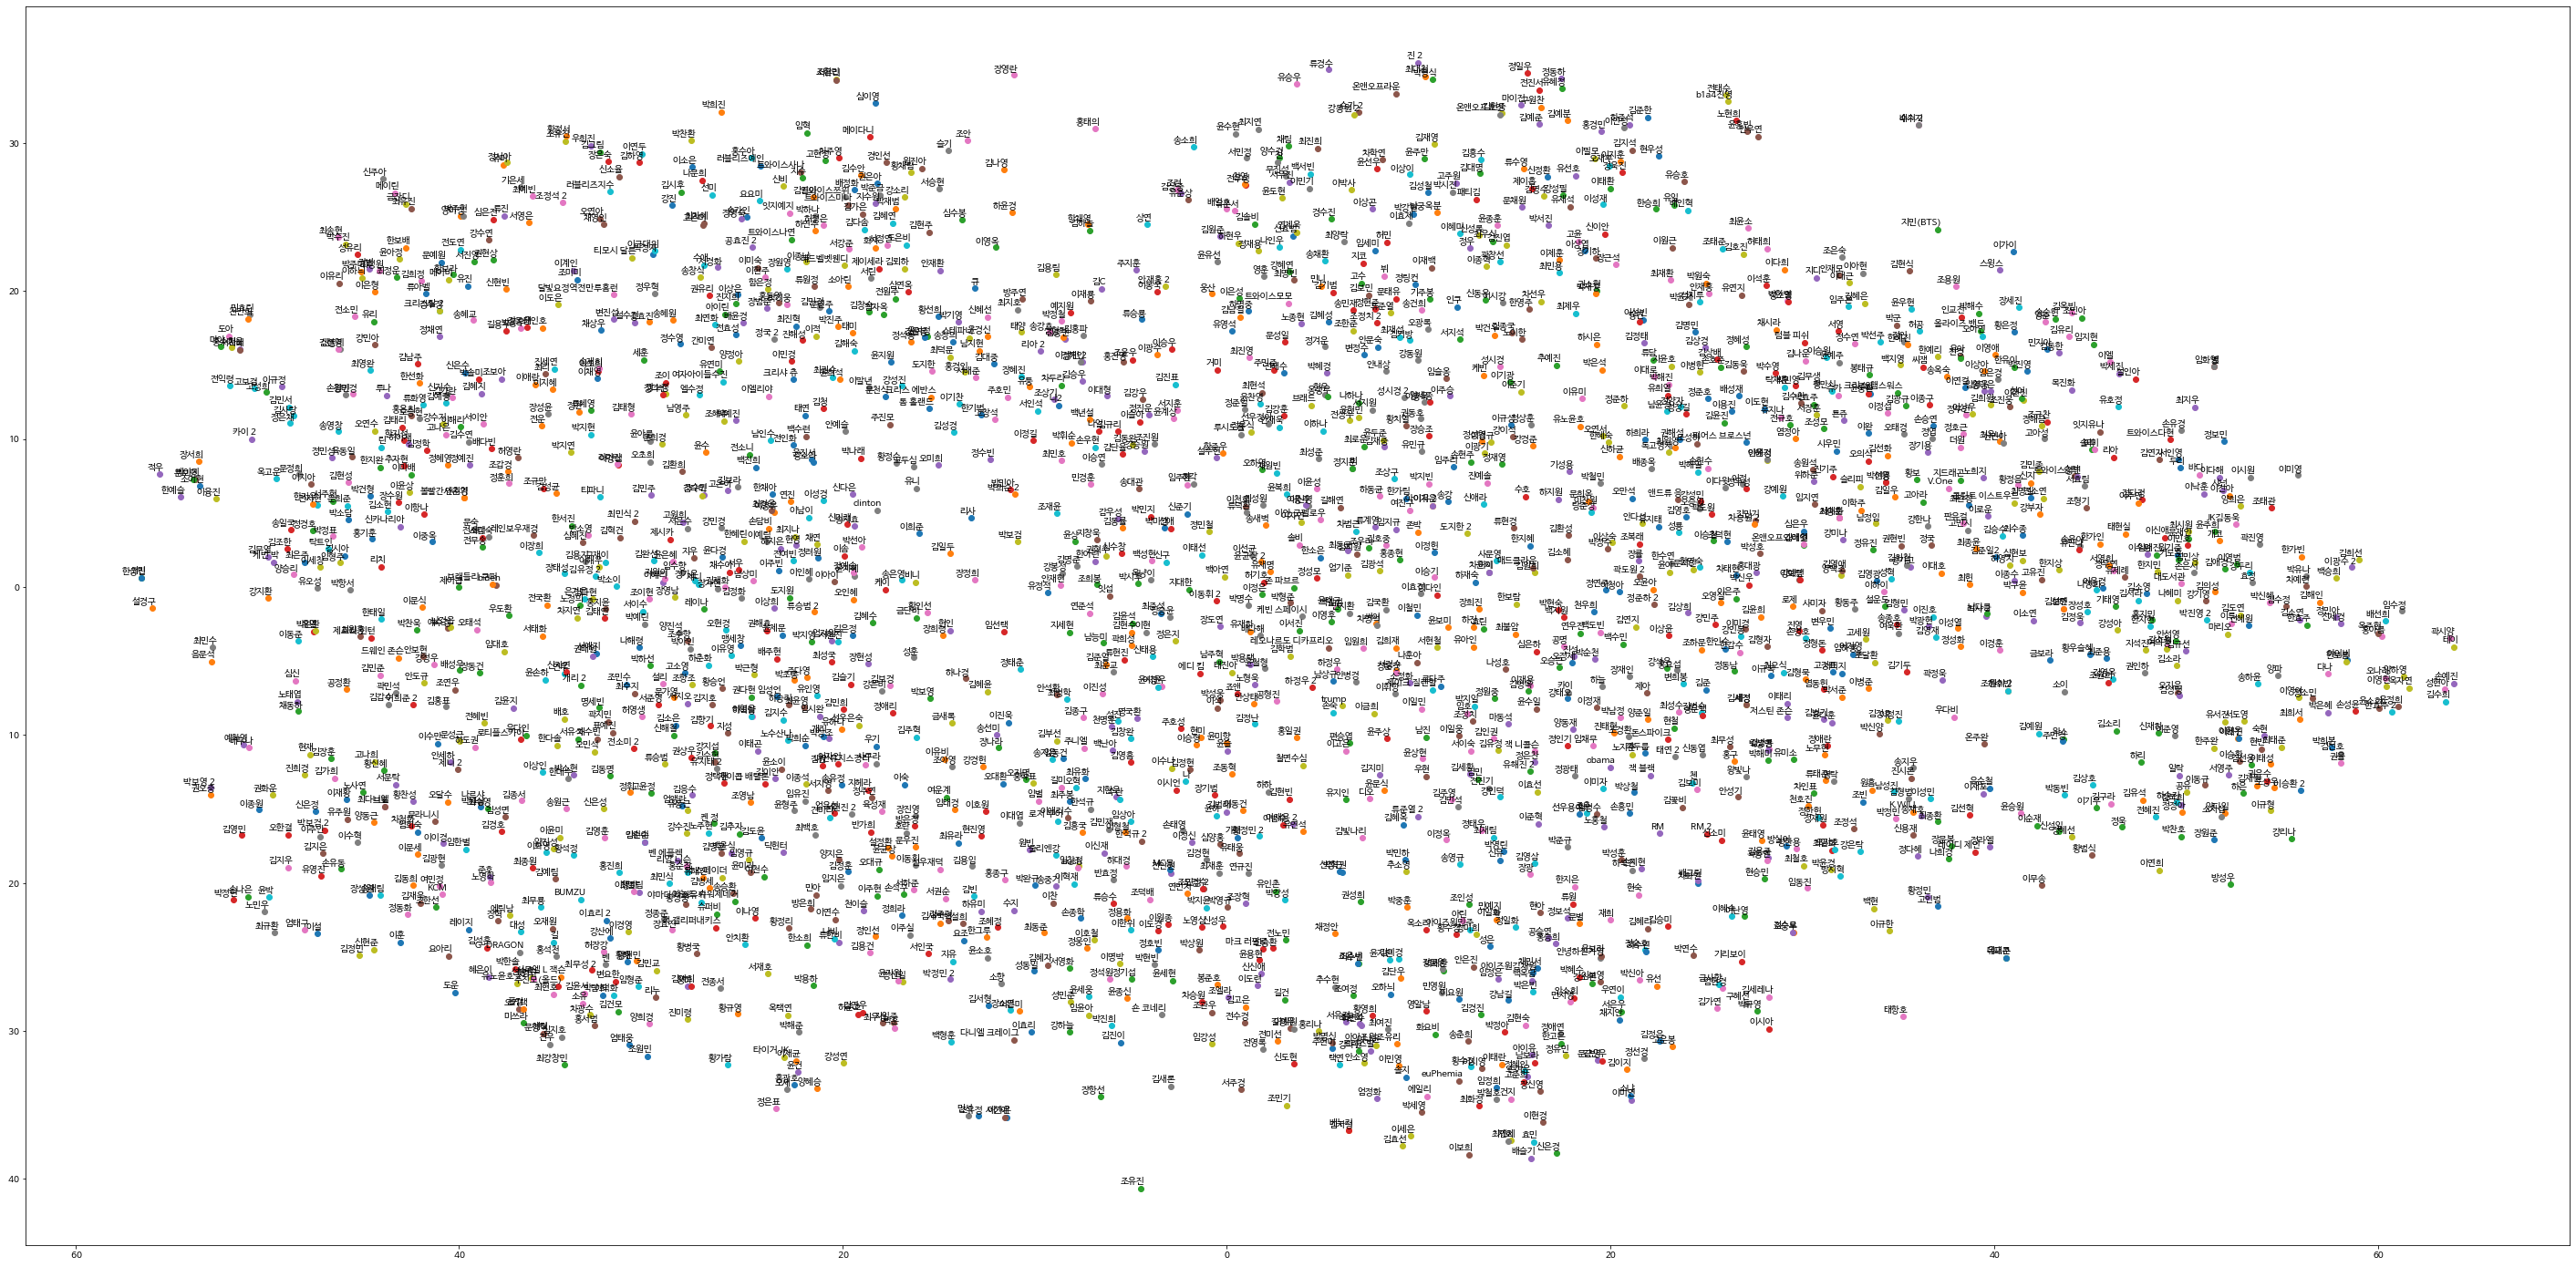

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


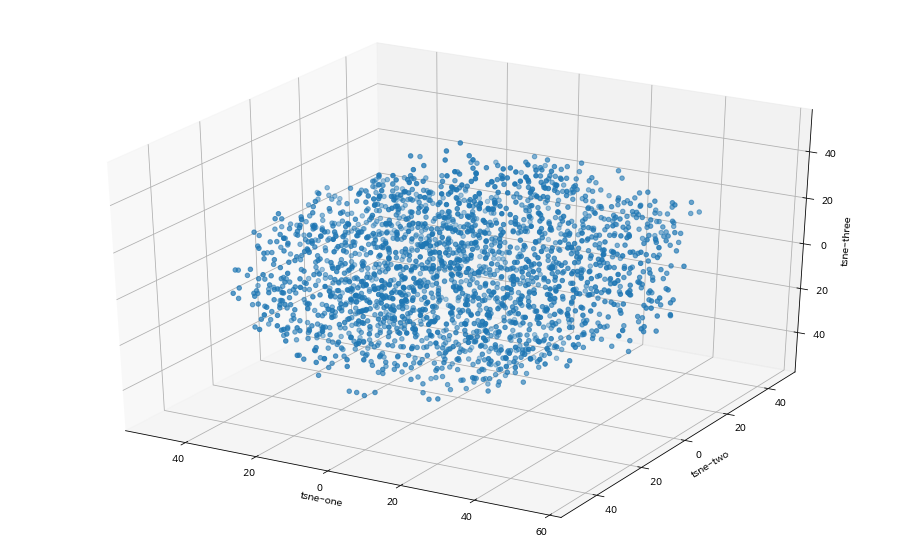

In [39]:
# 고차원 벡터인 얼굴 이미지 numpy array를 TSNE로 학습한 후 visualize
y = list(cropped_face_dict.keys())
model_tsne(X,y)

- 비슷한 이미지들끼리 어느정도 모여있는 모습이 보입니다. 근데 어딘가 조금 어설픈 것 같기도 합니다. 그래프를 확대한 아래 그림을 보면, 오달수 근처에 황찬성, 나르샤 등이 보이는데 닮았다고 별로 생각이 들지 않네요..!

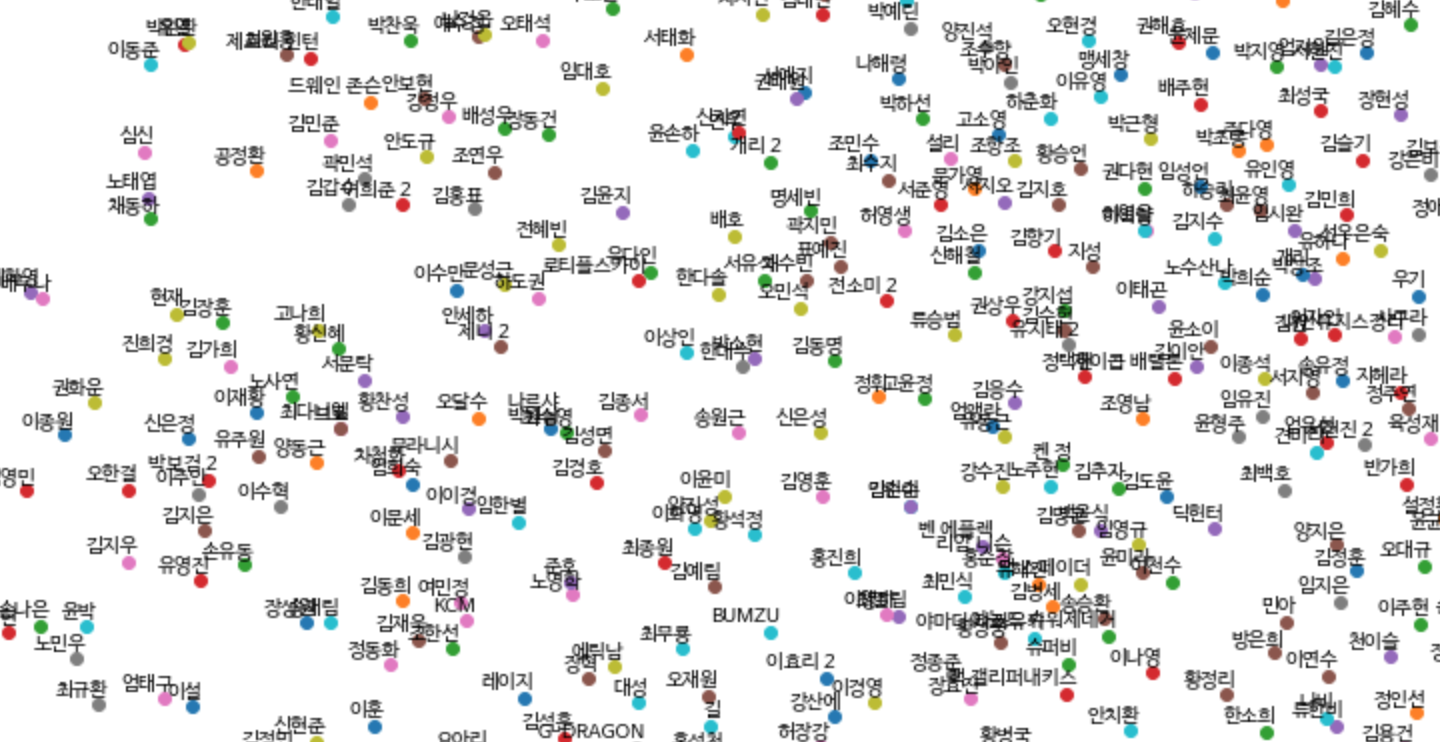

#### 2) 임베딩 벡터

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


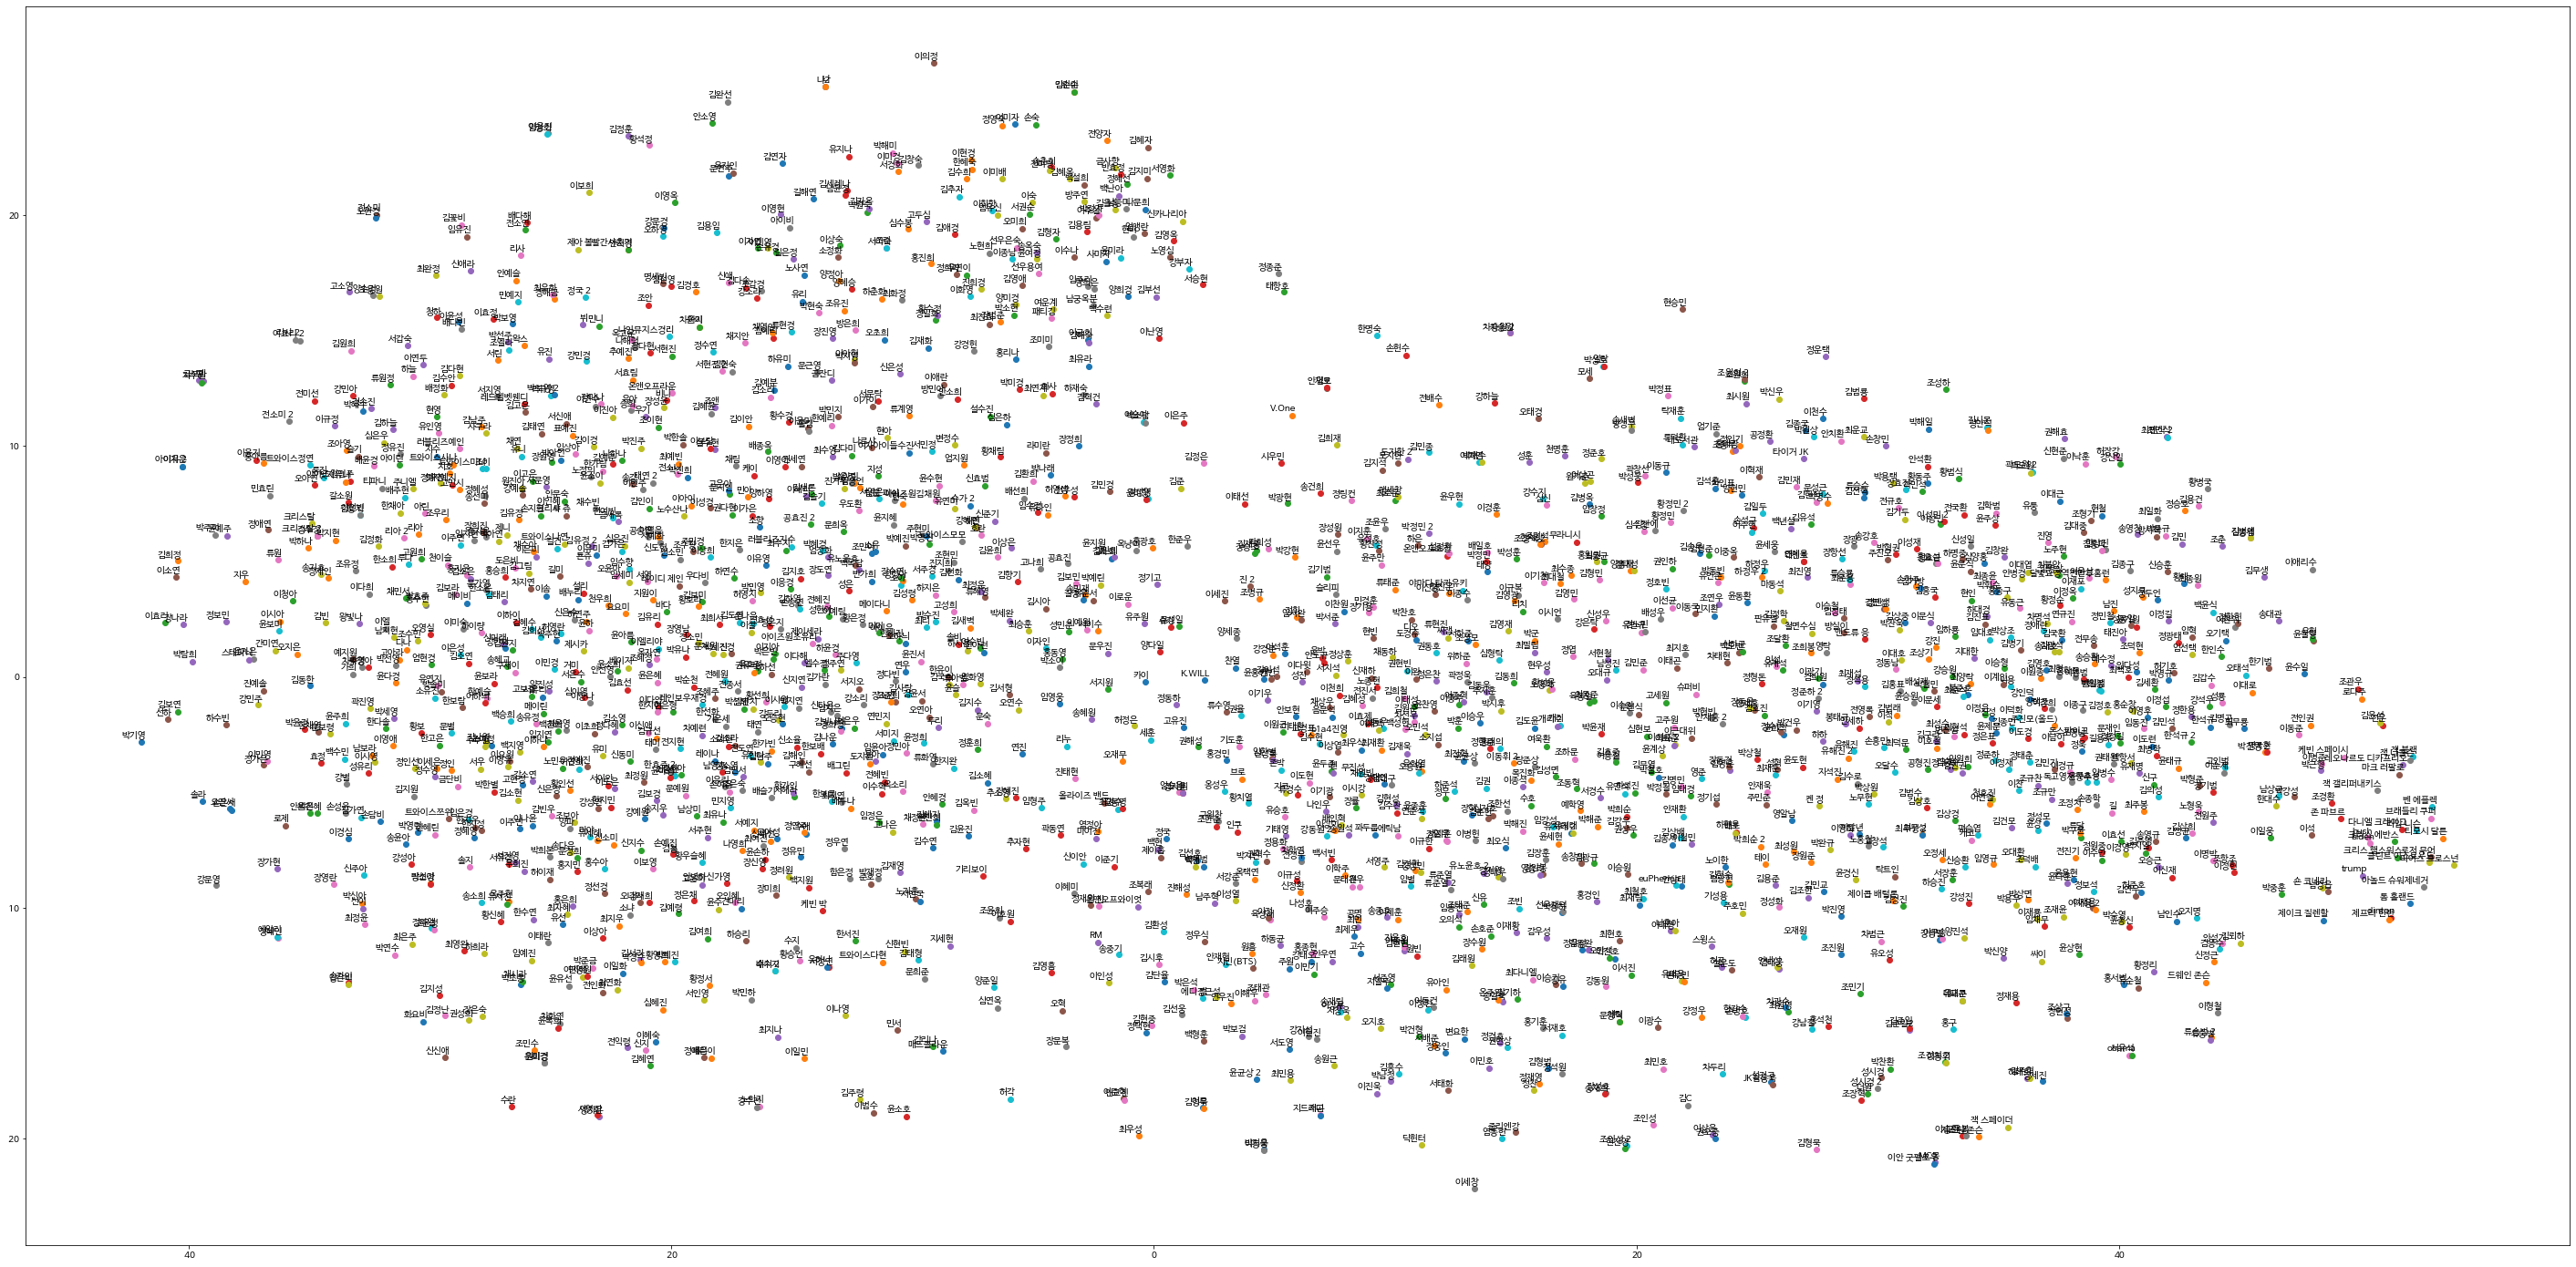

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


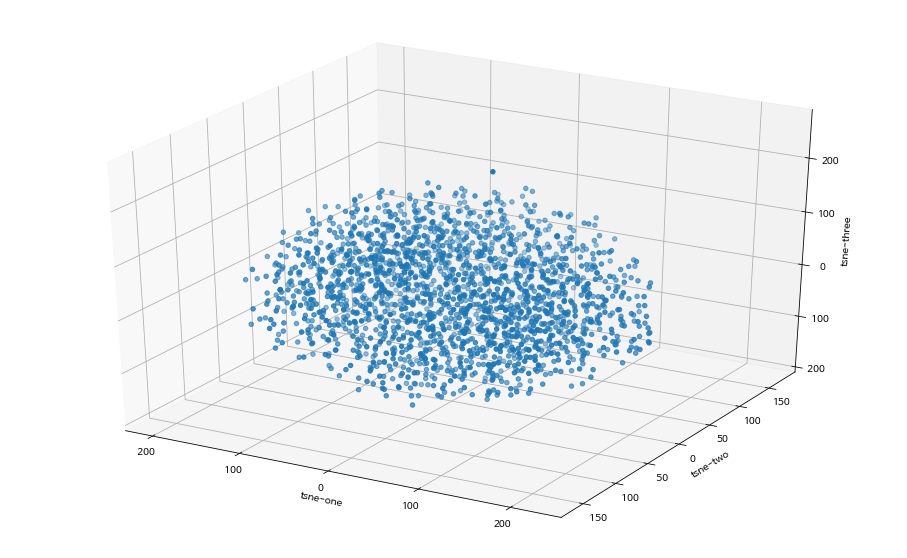

In [40]:
# TSNE 모델을 이용해서 embedding vector를 visualize해봅니다.
model_tsne(vectors, labels)

- 데이터가 많아서 한눈에 다 들어오지는 않지만, 왼쪽에는 주로 여자 연예인들이 모여 있고, 오른쪽에는 남자 연예인들이 분포하고 있습니다. 아무래도 성별이 같은 사람들끼리 더 비슷한 구석이 많으니까요. 
- 위의 고차원 벡터보다 임베딩 벡터를 tsne 모델로 시각화했을 때 비슷한 이미지들끼리 더 가깝게 모여있는 것을 볼 수 있었습니다.
- 아래 사진들은 위의 그래프를 확대한 사진입니다. 여자 연예인들 중에서는 '성유리','남보라','이시영'이 비슷하게 모여있는 등을 확인할 수 있습니다. 조금 느낌이 비슷한 것 같으신가요?
- 남자 연예인에서는 '유해진'이 자기 자신인 '유해진2'와 아주 가까이 위치해있고, 근처에는 '손흥민', '오달수', '하하'가 있네요..!

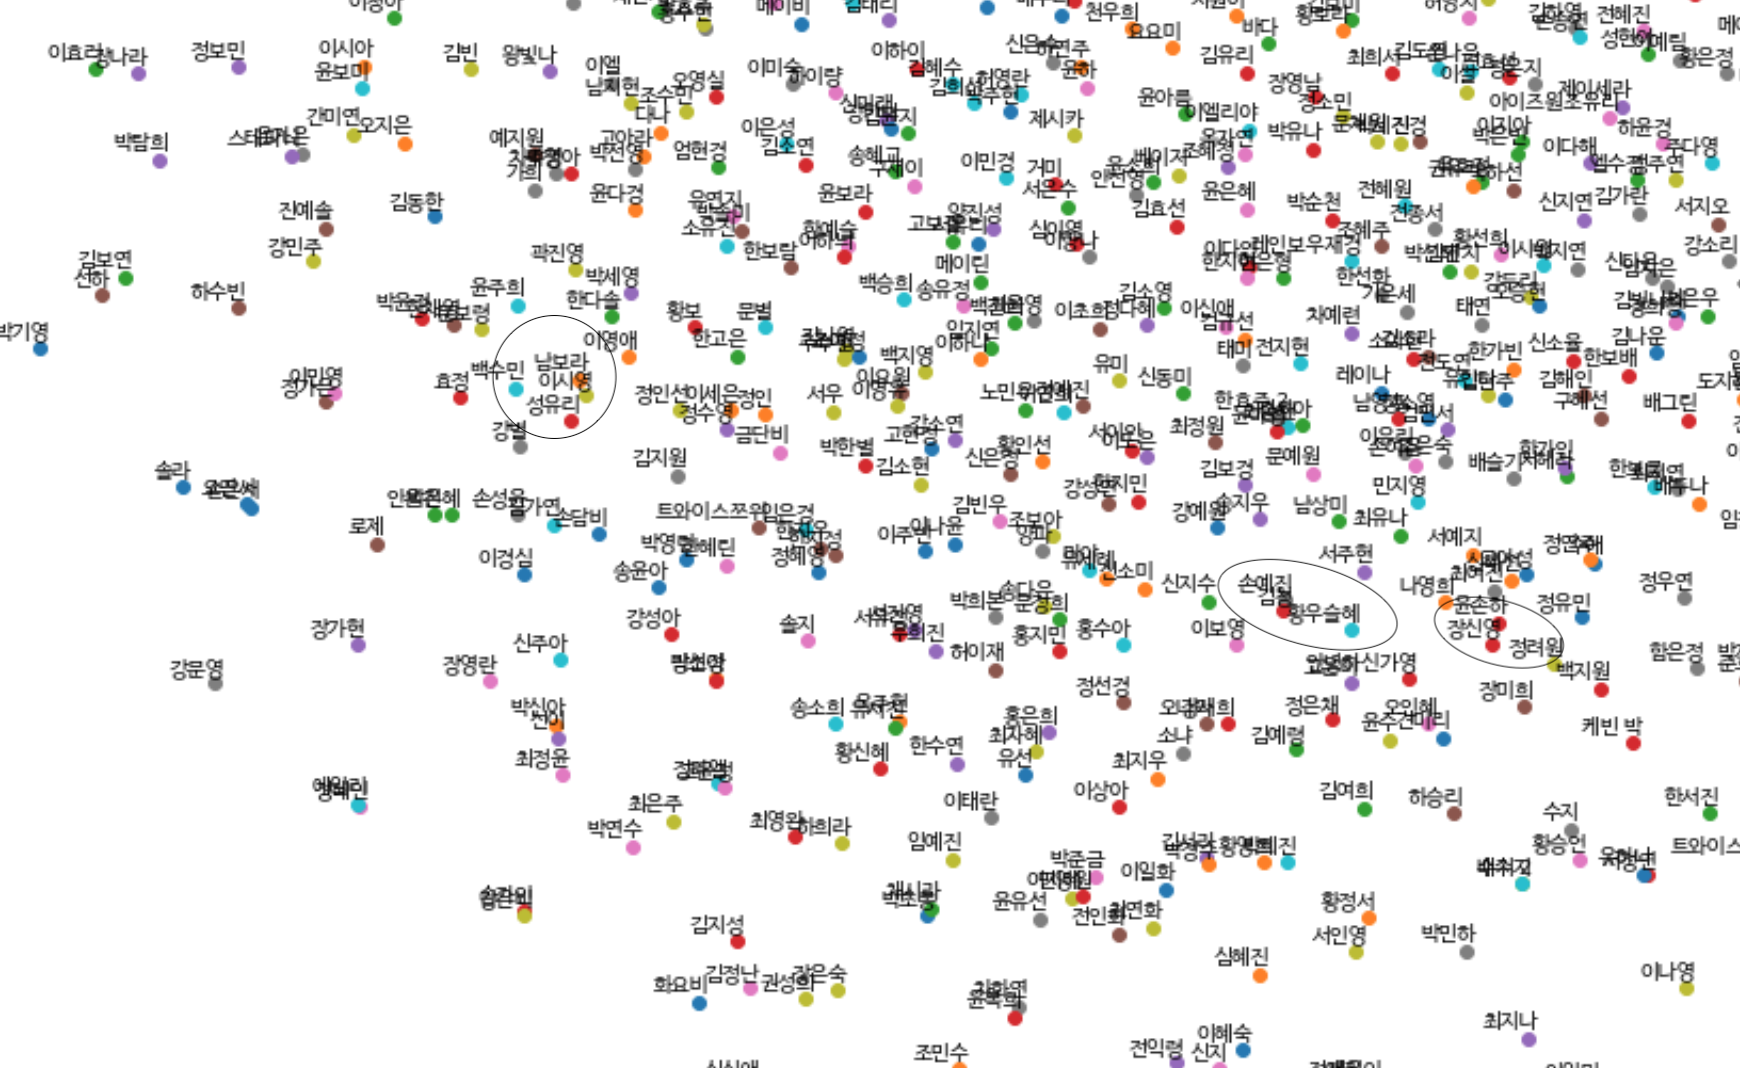

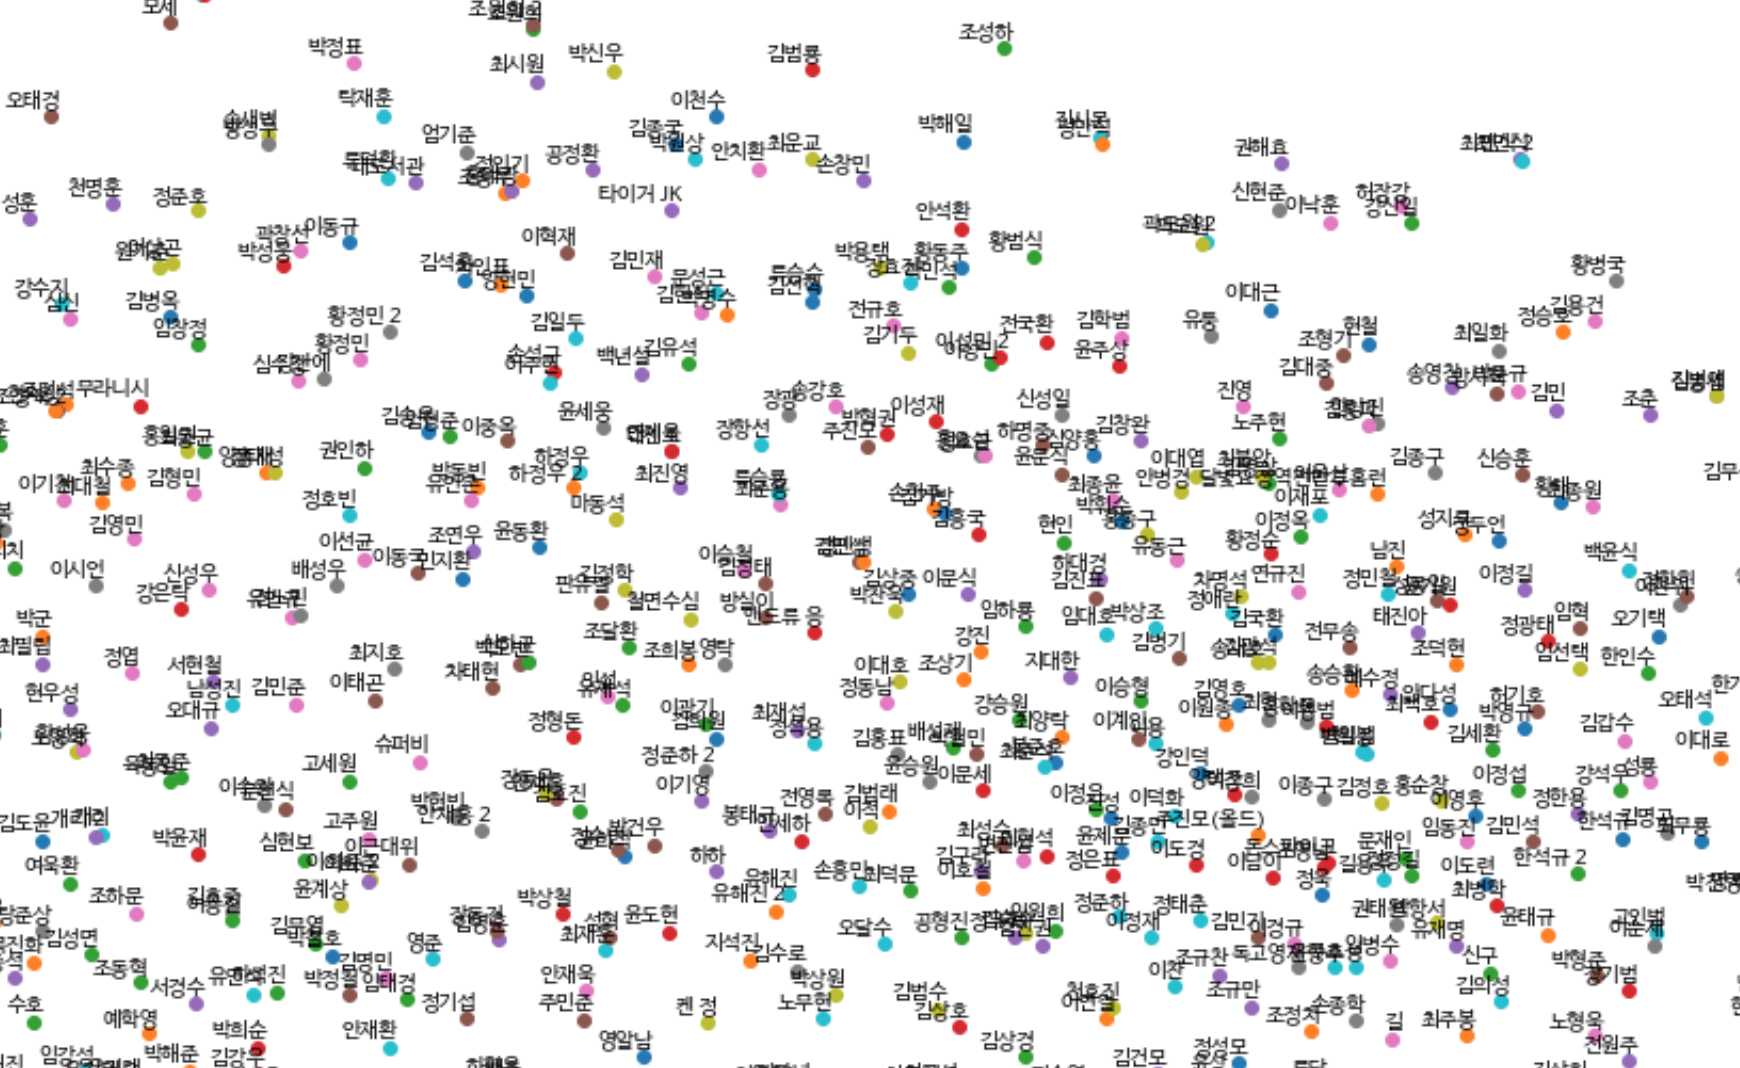

# 4. 회고
이미지는 몇십, 몇백, 몇천만 이상의 차원을 가진 숫자 배열로 표현됩니다. 상상할 수도 없는 고차원 벡터를 직접 일일이 비교하는 것은 당연히 불가능한 일이니, 기계의 도움을 받아야합니다. 이 고차원의 이미지 벡터에서 특성들을 추출해서 저차원 임베딩 벡터로 임베딩을 하는 것은 벡터 간 거리를 비교해서 비슷한 이미지들을 찾을 때 유용합니다.

이번 실습을 통해서는, face_recognition이라는 모듈과도 익숙해질 수 있었고, 벡터 간 거리를 구하는 것에 대해서도 배울 수 있었습니다. 또한, 시각화 tool로 PCA, t-SNE(확률적 방법으로 2차원 평면에 시각화)를 활용해볼 수 있었습니다. 이미지의 특성들에서 성분을 뽑아내서 이미지들 간 비교가 가능하며 이것을 시각적으로 보여주는 다양한 방식에 대해서 학습할 수 있었습니다. 하지만 이번 실습에서 대략 2000명 유명인(thanks to 아지트에 이미지 올려주신분들)의 얼굴을 임베딩 벡터로 변환한 데이터를 모두 시각화하였기에 보기가 어려웠던 점이 아쉬웠습니다. 데이터를 비슷한 특성을 가진 그룹별로 간추려서 시각화하면 더 좋을 것 같습니다. 자연어처리이든, 이미지 처리이든 임베딩 벡터를 생성할 수 있기 때문에 벡터 간 거리를 구해서 단어 혹은 이미지가 얼마나 비슷한지를 기계가 출력해주는 것이 유용해보입니다.